Using the nwb_photostim package

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pynwb import NWBFile
from file_classes import SpatialLightModulator, PhotostimulationDevice, HolographicPattern, PhotostimulationSeries, PhotostimulationTable
import numpy as np
from dateutil.tz import tzlocal
from pynwb import NWBHDF5IO
from datetime import datetime

## Spatial light modulator

In [3]:
slm = SpatialLightModulator(name='example_SLM', description="example SLM", manufacturer="SLM manufacturer", size=[500, 500])

## PhotostimulationDevice

In [4]:
photostim_dev = PhotostimulationDevice(name='photostimulation_device', description="example photostimulation device",
                                       manufacturer="device manufacturer", type='LED', wavelength=320, opsin="example opsin")
photostim_dev.add_slm(slm)

nwbfile = NWBFile('my first synthetic recording','EXAMPLE_ID',datetime.now(tzlocal()))
nwbfile.add_device(photostim_dev)

photostimulation_device file_classes.PhotostimulationDevice at 0x140439271843408
Fields:
  description: example photostimulation device
  manufacturer: device manufacturer
  opsin: example opsin
  slm: example_SLM file_classes.SpatialLightModulator at 0x140439271841776
Fields:
  description: example SLM
  manufacturer: SLM manufacturer
  size: [500 500]

  type: LED
  wavelength: 320

## Holographic stimulation pattern

The container `HolographicPattern` is used to store data corresponding to the pattern of stimulation for a given trial. The primary
input to the function is a set of ROIs, that denote whether a given pixel is stimulated (encoded as 1) or not stimulated (encoded as 0)
when that stimulus is presented. There are two ways to specify the ROIs: as an `image_mask_roi` or a `pixel_roi` (described below).

### ROIs specified using an image mask

In the `image_mask_roi`, the input to `HolographicPattern` is an array or list with dimensionality `[width, height]` or `[width, height, depth`] covering the entire field of view. ROIs that are stimulated are encoded by 1 values, and unstimulated regions by zeros.

In the example below, we simulate a `[50, 50]` pixel field of view, and randomly select 5 ROIs with a width and height of 5 pixels. To store the pattern in a `HolographicPattern` object, we use specify the ROIs using the `mask_roi` input argument on construction. A helper method `show_mask()` shows the simulated stimulated regions.

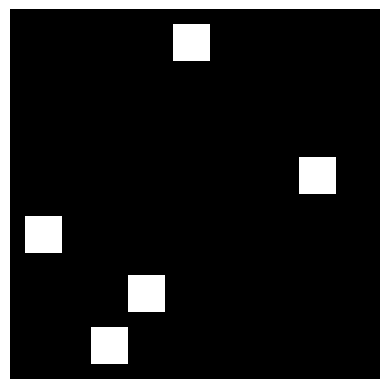

In [5]:
image_mask_roi = np.zeros((50, 50))

n_rois = 5
for _ in range(n_rois):
    x = np.random.randint(0, 45)
    y = np.random.randint(0, 45)
    image_mask_roi[x:x + 5, y:y + 5] = 1

hp_1 = HolographicPattern(name='pattern 1', image_mask_roi=image_mask_roi)
hp_1.show_mask()

### ROIs specified by the center and diameter of each region

Additionally, we provide a second method for specifying ROIs, the `pixel_roi`. `pixel_roi` inputs are a two- or three-dimensional vector of size `[num_rois, 3]` (in 2D stimulation) or `[num_rois, 4]` (in 3D stimulation). In the 2D case, `pixel_roi` takes the form `[(x1, y1), (x2, y2), ...]`, where `x` and `y` values correspond with the center of the ROI (in pixels). Similarly, in the 3D case, each element in the input takes the form `(x, y, z)`, where `z` denotes the depth of stimulation.

As compared to `image_mask_roi`, `pixel_roi` construction require two additional specifications: `stimulation_diameter` and `dimension`. `stimulation_diameter` denotes, in pixels, the radius of the ROI centered at input location `(x, y)` or `(x, y, z)`. That is, each row of `pixel_roi` corresponds to an ROI at a given location, extending `stimulation_diameter` pixels in every direction. Additionally, the dimensions of the field of view, in pixels, must be specified by the `dimension` parameter, where `dimension=[width, height]` or `[width, height, depth]`.

An example of a `HolographicPattern` with a `pixel_roi` input is shown below. This example includes 5 randomly-selected ROIs in a `[100, 100]` field of view, with a `stimulation_diameter` of 8 pixels. We use the helper function `show_mask()` to visualize the pattern.

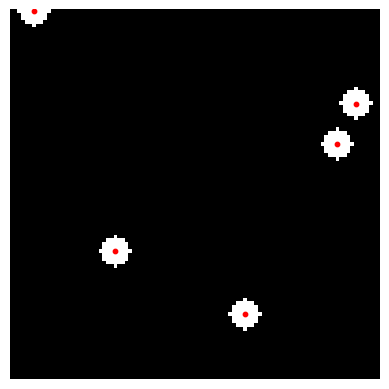

In [6]:
pixel_roi = []

for i in range(5):
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    for ix in range(x, x + 1):
        for iy in range(y, y + 1):
            pixel_roi.append((ix, iy))

hp_2 = HolographicPattern(name='pattern 2', pixel_roi=pixel_roi, ROI_size=8, dimension=[100, 100])
hp_2.show_mask()

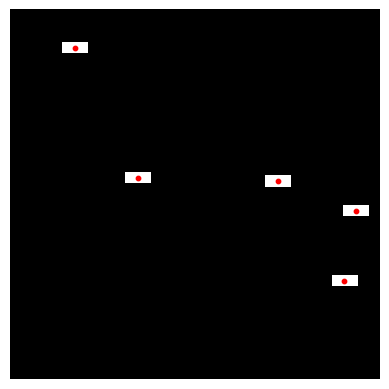

In [7]:
pixel_roi = []

for i in range(5):
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    for ix in range(x, x + 1):
        for iy in range(y, y + 1):
            pixel_roi.append((ix, iy))

hp_2 = HolographicPattern(name='pattern 2', pixel_roi=pixel_roi, ROI_size=[6, 2], dimension=[100, 100])
hp_2.show_mask()

## Stimulation series

The presentation of a given stimulation pattern over time is stored via the `PhotostimulationSeries` container.



### Interval format

In the `'interval'` format, we store the onset and cessation of stimulus presentation using a 1D array consisting of the values 1 (stimulus on) and -1 (stimulus off). The corresponding times for the start and stop of the stimulus are specified via the `timestamps` property, where `data[i]==1` denotes that the stimulus was presented at time `timestamps[i]`, and `data[i+1]==-1` denotes it stopped at time `timestamps[i+1]` (time is specified in seconds). For example, in the cell below, we note that pattern `hp_1` was presented from seconds `0.5` to `1`, and then again from seconds `2` to `4`.

In [8]:
stim_series_1 = PhotostimulationSeries(name="series 1", format='interval', holographic_pattern=hp_1, data=[1, -1, 1, -1], timestamps=[0.5, 1, 2, 4])

[ 1 -1  1 -1] [0.5 1.  2.  4. ]


While we can specify the `data` and `timestamps` directly, we can also initialize an empty `PhotostimulationSeries` (by not providing a `data` or `timestamps` input), and use the function `add_interval(start, stop)` to store the presentation of the stimulus from time `start` to time `stop`. In the example below, the first call indicates presentation of the stimulus between seconds `10` and `20`, and then again from seconds `35` to `40`. We can call the helper method `to_dataframe()` to display `data` and `timestamps` simultaneously.

In [9]:
stim_series_2 = PhotostimulationSeries(name="series 2", format='interval',  data=[1, -1, 1, -1], timestamps=[0.5, 1, 2, 4], holographic_pattern=hp_2)
stim_series_2.add_interval(10., 20.)
stim_series_2.add_interval(35., 40.)

print(stim_series_2.to_dataframe())

[ 1 -1  1 -1] [0.5 1.  2.  4. ]
   data  timestamps
0     1         0.5
1    -1         1.0
2     1         2.0
3    -1         4.0
4     1        10.0
5    -1        20.0
6     1        35.0
7    -1        40.0


### Series format

In addition to the interval format, we can also encode presentation time series data as a "series." In this format, rather than indicating the start and stop of stimulation,`data` consists of a 1D array of 0s and 1s denoting whether a stimulus was on or off at a given time step. In the example below, we note that the data is `[0, 1, 0, 1, 1, 0]`, the rate (i.e., the rate at which data are sampled, in Hz) is `10`, and the `stimulus_duration` is `0.05` (meaning that, at each time point where the stimulus is "on", denoted by a value of 1, it remains on for 0.05 seconds). In the case of the fourth element (`data[3]=1`), for example, the `rate` indicates that this point corresponds to 0.4 seconds into the trial (since `rate=10`, meaning there are 10 evenly-sampled data points per second). Since the value of the element is `1`, the stimulus was presented at that time, for `stimulus_duration=0.05` seconds. Expressed as an interval, the fourth time step indicates the stimulus was presented from *t*=0.4 to *t=0.05*.

While less easily interpretable, we include `format=`series'` as an option for the time series format because it may more closely align with the data collection modalities used in photostimulation methods.

In [10]:
stim_series_3 = PhotostimulationSeries(name="series 3", holographic_pattern=hp_1, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1, 1, 0], rate=10.)
print(stim_series_3.to_dataframe())

   data  timestamps
0     0         0.0
1     1         0.1
2     0         0.2
3     1         0.3
4     1         0.4
5     0         0.5


In the example above, we use the `rate` parameter instead of `timestamps` to express the times `data` correspond to. In the `'series'` format, we can still specify timestamps directly, as we did for the interval series. Here, the data `data[i]` corresponds to an interval beginning at time `timestamps[i]` and ending at time `timestamps[i]+stimulus_duration`. Note that `PhotostimulationSeries` requires one of either `rate` or `timestamps` to be specified for the series format, in order for data to be added.

In addition to adding data directly, we can also add data using the `add_onset(time)` method, which denotes the onset of the stimulus at time `time` (for duration `stimulus_duration`).

In [11]:
stim_series_4 = PhotostimulationSeries(name="series 4", holographic_pattern=hp_2, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1], timestamps=[0, 0.5, 2, 4])
stim_series_4.add_onset(5)
stim_series_4.add_onset([10, 14, 50])
print(stim_series_4.to_dataframe())

   data  timestamps
0     0         0.0
1     1         0.5
2     0         2.0
3     1         4.0
4     1         5.0
5     1        10.0
6     1        14.0
7     1        50.0


The `add_presentation` function also works for the `'interval'` format:

In [12]:
stim_series_5 = PhotostimulationSeries(name="series 5", format='interval', holographic_pattern=hp_1, stimulus_duration=2)
stim_series_5.add_onset(1)
stim_series_5.add_onset([10, 18, 24])
print(stim_series_5.to_dataframe())

   data  timestamps
0   1.0         1.0
1  -1.0         3.0
2   1.0        10.0
3  -1.0        12.0
4   1.0        18.0
5  -1.0        20.0
6   1.0        24.0
7  -1.0        26.0


In [13]:
for stim in [stim_series_1, stim_series_2, stim_series_3, stim_series_4, stim_series_5]:
# for stim in [stim_series_5]:
    nwbfile.add_stimulus(stim)

## PhotostimulationTable

In [14]:
sp = PhotostimulationTable(name='test', description='test desc', photostimulation_device=photostim_dev, stimulus_method='asas', sweeping_method="sweeping_method",
                           time_per_sweep=0.01, num_sweeps=10)
sp.add_series([stim_series_1, stim_series_2, stim_series_3, stim_series_4, stim_series_5])
# sp.add_series([stim_series_5])
print(sp.to_dataframe())

         row series_name series_format  num_samples  start_time  stop_time  \
id                                                                           
0   series_0    series 1      interval            4         0.0       4.00   
1   series_1    series 2      interval            8         0.0      40.00   
2   series_2    series 3        series            6         0.0       0.25   
3   series_3    series 4        series            8         0.0      50.00   
4   series_4    series 5      interval            8         0.0      26.00   

   pattern_name                            photostimulation_series  
id                                                                  
0     pattern 1  series 1 file_classes.PhotostimulationSeries a...  
1     pattern 2  series 2 file_classes.PhotostimulationSeries a...  
2     pattern 1  series 3 file_classes.PhotostimulationSeries a...  
3     pattern 2  series 4 file_classes.PhotostimulationSeries a...  
4     pattern 1  series 5 file_classes.

### Plotting PhotostimulationTable timestamps

The timestamps for each series in the `PhotostimulationTable` can be plotted simultaneously using the visualization function `plot()`.

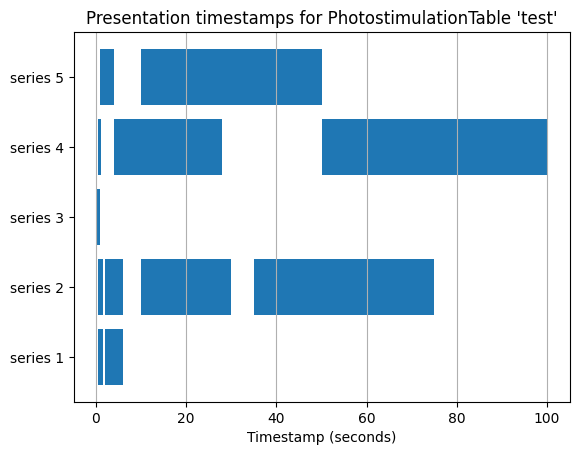

In [15]:
sp.plot()

### Creating a photostimulation processing module

In [16]:
behavior_module = nwbfile.create_processing_module(name="holographic_photostim", description="initial data")
behavior_module.add(sp)

test file_classes.PhotostimulationTable at 0x140438862466448
Fields:
  colnames: ['row' 'series_name' 'series_format' 'num_samples' 'start_time'
 'stop_time' 'pattern_name' 'photostimulation_series']
  columns: (
    row <class 'hdmf.common.table.VectorData'>,
    series_name <class 'hdmf.common.table.VectorData'>,
    series_format <class 'hdmf.common.table.VectorData'>,
    num_samples <class 'hdmf.common.table.VectorData'>,
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    pattern_name <class 'hdmf.common.table.VectorData'>,
    photostimulation_series <class 'hdmf.common.table.VectorData'>
  )
  description: test desc
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  num_sweeps: 10
  photostimulation_device: photostimulation_device file_classes.PhotostimulationDevice at 0x140439271843408
Fields:
  description: example photostimulation device
  manufacturer: device manufacturer
  opsin: example opsin
  slm: examp

## Writing the file

In [17]:
import os
os.remove("basics_tutorial.h5")
with NWBHDF5IO("basics_tutorial.h5", "w") as io:
    io.write(stim_series_2)

## Reading the file

In [18]:
with NWBHDF5IO("basics_tutorial.h5", "r", load_namespaces=True) as io:
    read_nwbfile = io.read()
print(read_nwbfile)

<HDF5 dataset "data": shape (8,), type "<i8"> <HDF5 dataset "timestamps": shape (4,), type "<f8">


ConstructError: (root GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'no description', 'format': 'interval', 'namespace': 'test', 'neurodata_type': 'PhotostimulationSeries', 'object_id': '3579ed68-6734-4c9b-a804-0e3610ee8fac'}, 'groups': {'pattern 2': root/pattern 2 GroupBuilder {'attributes': {'dimension': array([100, 100]), 'namespace': 'test', 'neurodata_type': 'HolographicPattern', 'object_id': '9b8ae8a5-4be1-46bd-b608-140a938cf83b'}, 'groups': {}, 'datasets': {'pixel_roi': root/pattern 2/pixel_roi DatasetBuilder {'attributes': {'ROI_size': array([6, 2])}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {'data': root/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, "Could not construct PhotostimulationSeries object due to: 'data' and 'timestamps' need to be the same length")

In [ ]:
print(read_nwbfile.processing['holographic_photostim'])